Training set: 54000 samples
Validation set: 6000 samples
Test set: 10000 samples
Input shape: (28, 28) (time_steps, features)
Visualizing sample images from each class:


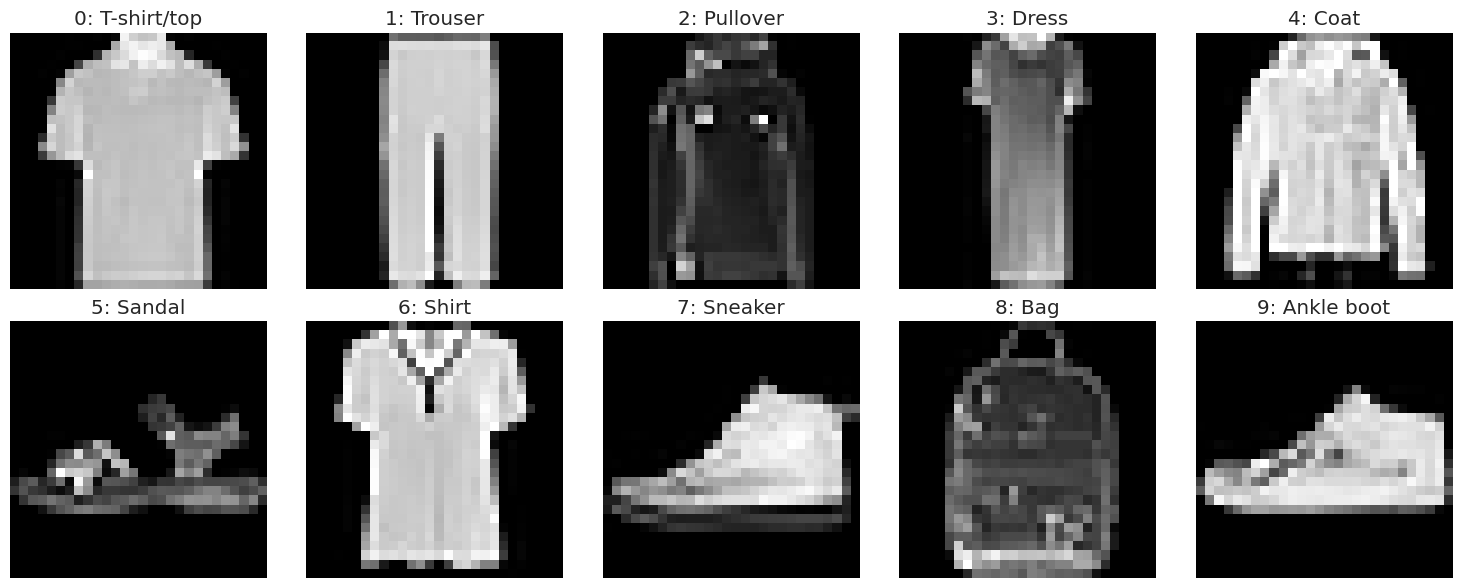

Training RNN model...
Epoch 1/10 - Loss: 0.9592 - Acc: 0.6629 - Val Loss: 0.7409 - Val Acc: 0.7205
Epoch 2/10 - Loss: 0.6221 - Acc: 0.7773 - Val Loss: 0.7004 - Val Acc: 0.7533
Epoch 3/10 - Loss: 0.5507 - Acc: 0.8062 - Val Loss: 0.5605 - Val Acc: 0.7998
Epoch 4/10 - Loss: 0.5027 - Acc: 0.8218 - Val Loss: 0.6234 - Val Acc: 0.7960
Epoch 5/10 - Loss: 0.4773 - Acc: 0.8296 - Val Loss: 0.4545 - Val Acc: 0.8375
Epoch 6/10 - Loss: 0.4572 - Acc: 0.8370 - Val Loss: 0.4600 - Val Acc: 0.8367
Epoch 7/10 - Loss: 0.4416 - Acc: 0.8429 - Val Loss: 0.4654 - Val Acc: 0.8335
Epoch 8/10 - Loss: 0.4298 - Acc: 0.8467 - Val Loss: 0.4974 - Val Acc: 0.8195
Epoch 9/10 - Loss: 0.4160 - Acc: 0.8504 - Val Loss: 0.5468 - Val Acc: 0.8117
Epoch 10/10 - Loss: 0.4083 - Acc: 0.8530 - Val Loss: 0.4210 - Val Acc: 0.8443
Training completed in 668.49 seconds


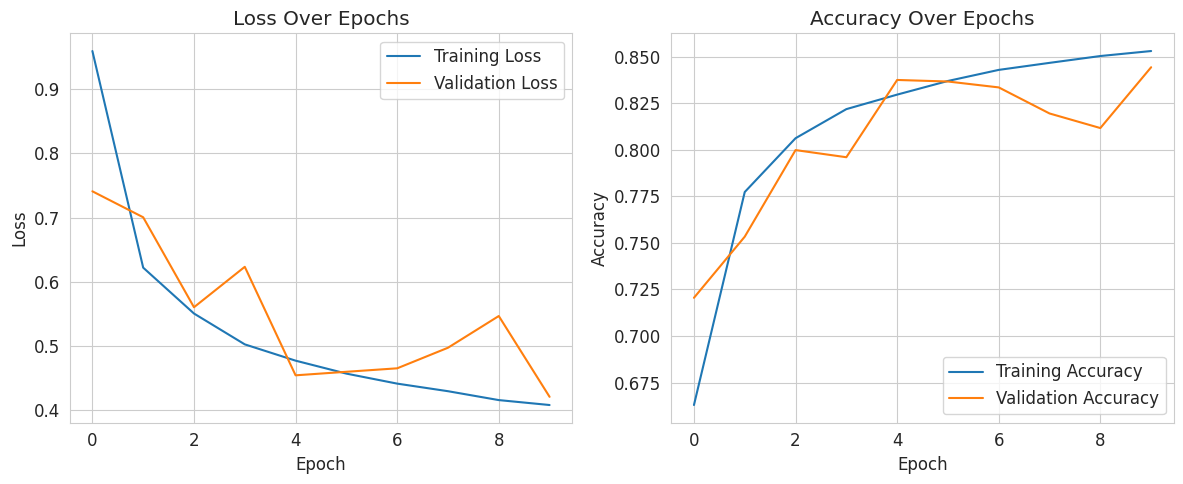


Evaluating RNN model on test set:
Accuracy: 0.8414
Precision: 0.8437
Recall: 0.8414
F1 Score: 0.8404


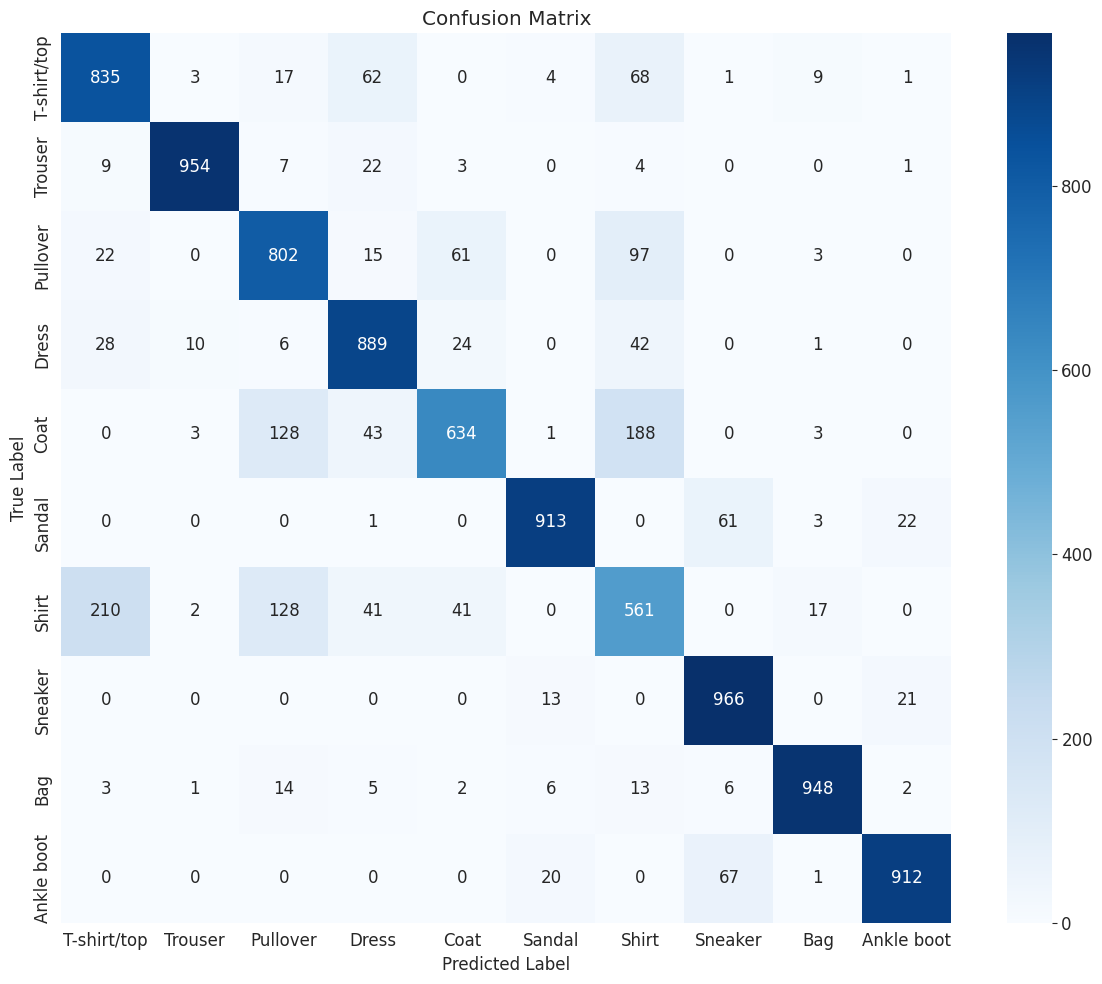

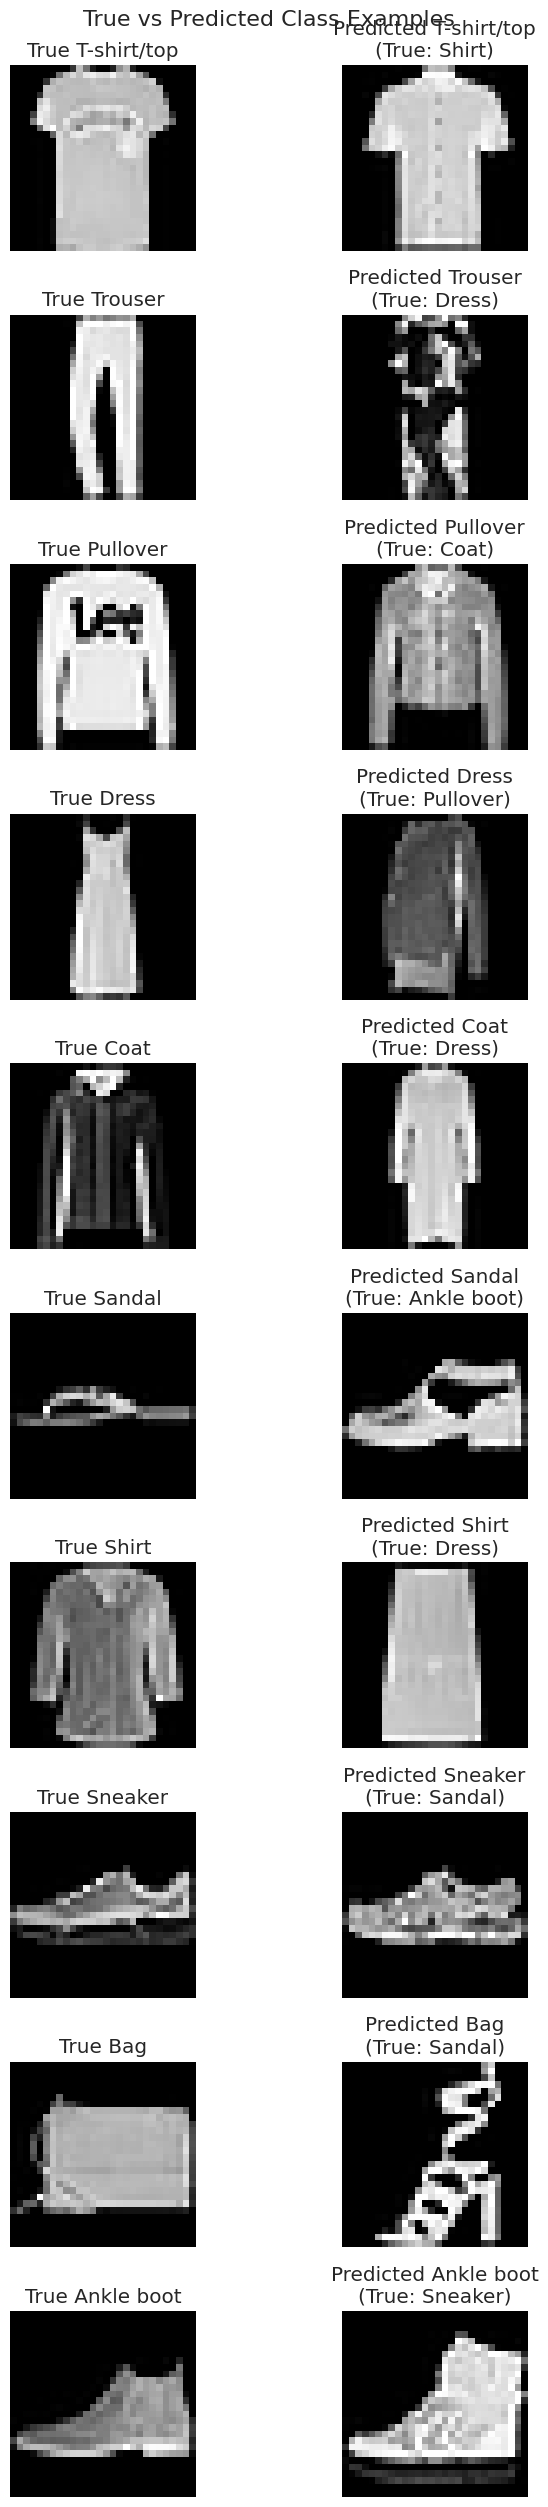

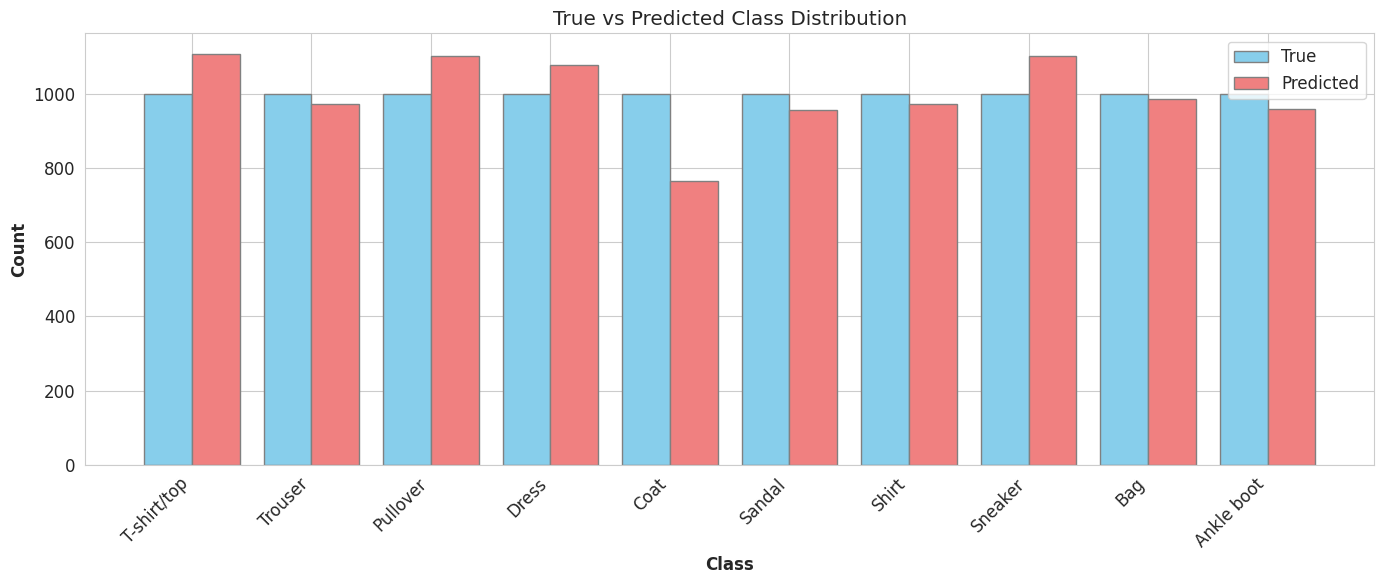

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Load Fashion MNIST dataset
def load_fashion_mnist():
    # Only using Keras/TensorFlow for dataset loading
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    # Normalize pixel values to [0, 1]
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0

    # For RNN, we'll treat each row of the image as a time step, with 28 features (columns)

    # One-hot encode labels
    y_train_onehot = one_hot_encode(y_train)
    y_test_onehot = one_hot_encode(y_test)

    return X_train, y_train_onehot, X_test, y_test_onehot, y_train, y_test

def one_hot_encode(y, num_classes=10):
    """Convert labels to one-hot encoding"""
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

# RNN from scratch
class RNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size  # Number of features per time step
        self.hidden_size = hidden_size  # Size of hidden state
        self.output_size = output_size  # Number of output classes
        self.learning_rate = learning_rate
        self.parameters = {}
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        # Initialize parameters
        # For RNN cell: h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b_h)
        # Xavier/Glorot initialization
        scale_xh = np.sqrt(2.0 / (input_size + hidden_size))
        scale_hh = np.sqrt(2.0 / (hidden_size + hidden_size))
        scale_hy = np.sqrt(2.0 / (hidden_size + output_size))

        self.parameters['Wxh'] = np.random.randn(input_size, hidden_size) * scale_xh  # Input to hidden
        self.parameters['Whh'] = np.random.randn(hidden_size, hidden_size) * scale_hh  # Hidden to hidden
        self.parameters['bh'] = np.zeros((1, hidden_size))  # Hidden bias

        # Output layer parameters
        self.parameters['Why'] = np.random.randn(hidden_size, output_size) * scale_hy  # Hidden to output
        self.parameters['by'] = np.zeros((1, output_size))  # Output bias

    def tanh(self, x):
        """Tanh activation function"""
        return np.tanh(x)

    def tanh_derivative(self, x):
        """Derivative of tanh: 1 - tanh^2(x)"""
        return 1 - np.power(np.tanh(x), 2)

    def softmax(self, x):
        """Softmax activation for output layer"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        """Cross-entropy loss function"""
        m = y_true.shape[0]
        # Add small epsilon to avoid log(0)
        log_probs = -np.log(y_pred + 1e-10) * y_true
        loss = np.sum(log_probs) / m
        return loss

    def forward_pass(self, X):
        """
        Forward propagation through the RNN
        X shape: (batch_size, time_steps, input_size)
        """
        batch_size, time_steps, _ = X.shape

        # Initialize hidden state with zeros
        h_prev = np.zeros((batch_size, self.hidden_size))

        # Store intermediate values for backpropagation
        cache = {
            'X': X,
            'h': {},
            'h_raw': {},  # Pre-activation hidden states
            'y_pred': {}
        }

        # Process each time step
        for t in range(time_steps):
            # Get current time step input
            x_t = X[:, t, :]

            # Compute hidden state
            h_raw_t = np.dot(x_t, self.parameters['Wxh']) + \
                      np.dot(h_prev, self.parameters['Whh']) + \
                      self.parameters['bh']
            h_t = self.tanh(h_raw_t)

            # Store values for backpropagation
            cache['h_raw'][t] = h_raw_t
            cache['h'][t] = h_t

            # Update previous hidden state
            h_prev = h_t

        # Final hidden state becomes the input to the output layer
        y_raw = np.dot(h_prev, self.parameters['Why']) + self.parameters['by']
        y_pred = self.softmax(y_raw)

        cache['y_raw'] = y_raw
        cache['y_pred'] = y_pred
        cache['h_last'] = h_prev  # Final hidden state

        return y_pred, cache

    def backward_pass(self, y_pred, y_true, cache):
        """
        Backward propagation through time (BPTT)
        """
        batch_size, time_steps, _ = cache['X'].shape
        gradients = {}

        # Initialize gradients
        gradients['dWxh'] = np.zeros_like(self.parameters['Wxh'])
        gradients['dWhh'] = np.zeros_like(self.parameters['Whh'])
        gradients['dbh'] = np.zeros_like(self.parameters['bh'])
        gradients['dWhy'] = np.zeros_like(self.parameters['Why'])
        gradients['dby'] = np.zeros_like(self.parameters['by'])

        # Gradient of output layer
        dy = y_pred - y_true  # Shape: (batch_size, output_size)
        gradients['dWhy'] = np.dot(cache['h_last'].T, dy) / batch_size
        gradients['dby'] = np.sum(dy, axis=0, keepdims=True) / batch_size

        # Gradient flowing back to the last hidden state
        dh_next = np.dot(dy, self.parameters['Why'].T)

        # Backpropagate through time
        for t in reversed(range(time_steps)):
            # Gradient through tanh
            dh_raw = dh_next * self.tanh_derivative(cache['h_raw'][t])

            # Gradient of biases
            gradients['dbh'] += np.sum(dh_raw, axis=0, keepdims=True) / batch_size

            # Gradient of weight matrices
            x_t = cache['X'][:, t, :]
            gradients['dWxh'] += np.dot(x_t.T, dh_raw) / batch_size

            # For Whh, we need the previous hidden state, except for t=0
            if t > 0:
                h_prev = cache['h'][t-1]
            else:
                h_prev = np.zeros((batch_size, self.hidden_size))

            gradients['dWhh'] += np.dot(h_prev.T, dh_raw) / batch_size

            # Gradient flowing to the previous hidden state
            dh_next = np.dot(dh_raw, self.parameters['Whh'].T)

        # Clip gradients to mitigate exploding gradients
        for key in gradients:
            np.clip(gradients[key], -5, 5, out=gradients[key])

        return gradients

    def update_parameters(self, gradients):
        """Update parameters using gradients"""
        for key in self.parameters:
            self.parameters[key] -= self.learning_rate * gradients['d' + key]

    def train(self, X_train, y_train, X_val=None, y_val=None, batch_size=32, epochs=10):
        """Train the RNN model"""
        num_samples = X_train.shape[0]
        num_batches = int(np.ceil(num_samples / batch_size))

        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(num_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            epoch_loss = 0
            correct_predictions = 0

            for batch in range(num_batches):
                start_idx = batch * batch_size
                end_idx = min(start_idx + batch_size, num_samples)

                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # Forward pass
                y_pred, cache = self.forward_pass(X_batch)

                # Calculate loss
                batch_loss = self.cross_entropy_loss(y_pred, y_batch)
                epoch_loss += batch_loss * (end_idx - start_idx)

                # Count correct predictions
                batch_correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
                correct_predictions += batch_correct

                # Backward pass
                gradients = self.backward_pass(y_pred, y_batch, cache)

                # Update parameters
                self.update_parameters(gradients)

            # Calculate epoch metrics
            epoch_loss /= num_samples
            epoch_accuracy = correct_predictions / num_samples
            self.history['train_loss'].append(epoch_loss)
            self.history['train_acc'].append(epoch_accuracy)

            # Validation if provided
            if X_val is not None and y_val is not None:
                val_pred, _ = self.predict_with_batch(X_val, batch_size=batch_size)
                val_loss = self.cross_entropy_loss(val_pred, y_val)
                val_accuracy = np.mean(np.argmax(val_pred, axis=1) == np.argmax(y_val, axis=1))
                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_accuracy)
                print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_accuracy:.4f}")

    def predict_with_batch(self, X, batch_size=32):
        """Make predictions in batches to handle large datasets"""
        num_samples = X.shape[0]
        num_batches = int(np.ceil(num_samples / batch_size))

        all_preds = []
        all_caches = []

        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = min(start_idx + batch_size, num_samples)

            X_batch = X[start_idx:end_idx]
            y_pred, cache = self.forward_pass(X_batch)

            all_preds.append(y_pred)
            all_caches.append(cache)

        return np.vstack(all_preds), all_caches

    def predict(self, X):
        """Make predictions"""
        predictions, _ = self.predict_with_batch(X)
        return predictions

    def visualize_true_vs_predicted(self, X, y_true, class_names):
        """
        Visualize both true examples and predicted examples for each class

        Args:
            X: Input data
            y_true: True labels
            class_names: List of class names
        """
        # Get predictions
        y_pred = np.argmax(self.predict(X), axis=1)

        # Original shape of images
        n_rows = X.shape[1]  # Time steps
        n_cols = X.shape[2]  # Features per time step

        # Create a figure with subplots for each class (2 columns: true and predicted)
        fig, axes = plt.subplots(len(class_names), 2, figsize=(8, 25))

        for class_idx in range(len(class_names)):
            # Find samples with true label of this class
            true_indices = np.where(y_true == class_idx)[0]

            # Find samples predicted as this class
            pred_indices = np.where(y_pred == class_idx)[0]

            # True example
            if len(true_indices) > 0:
                true_img = X[true_indices[0]].reshape(n_rows, n_cols)
                axes[class_idx, 0].imshow(true_img, cmap='gray')
                axes[class_idx, 0].set_title(f"True {class_names[class_idx]}")
                axes[class_idx, 0].axis('off')
            else:
                axes[class_idx, 0].text(0.5, 0.5, "No samples", ha='center')
                axes[class_idx, 0].axis('off')

            # Predicted example (find examples where the model predicted this class)
            if len(pred_indices) > 0:
                # Find one that's not actually this class (misclassification) if possible
                misclassified = [idx for idx in pred_indices if y_true[idx] != class_idx]

                if len(misclassified) > 0:
                    # Show a misclassified example
                    pred_img = X[misclassified[0]].reshape(n_rows, n_cols)
                    true_label = y_true[misclassified[0]]
                    axes[class_idx, 1].imshow(pred_img, cmap='gray')
                    axes[class_idx, 1].set_title(f"Predicted {class_names[class_idx]}\n(True: {class_names[true_label]})")
                else:
                    # Show a correctly classified example
                    pred_img = X[pred_indices[0]].reshape(n_rows, n_cols)
                    axes[class_idx, 1].imshow(pred_img, cmap='gray')
                    axes[class_idx, 1].set_title(f"Predicted {class_names[class_idx]}\n(Correct)")

                axes[class_idx, 1].axis('off')
            else:
                axes[class_idx, 1].text(0.5, 0.5, "No predictions", ha='center')
                axes[class_idx, 1].axis('off')

        plt.tight_layout()
        plt.suptitle("True vs Predicted Class Examples", y=1.002, fontsize=16)
        plt.subplots_adjust(top=0.98)
        plt.show()

    def evaluate(self, X, y_true_onehot, y_true_labels, class_names=None):
        """Evaluate model performance with various metrics and visualize results"""
        # Get predictions
        y_pred = self.predict(X)
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred_labels == y_true_labels)
        conf_mat = confusion_matrix(y_true_labels, y_pred_labels)
        precision = precision_score(y_true_labels, y_pred_labels, average='macro')
        recall = recall_score(y_true_labels, y_pred_labels, average='macro')
        f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Plot confusion matrix
        plt.figure(figsize=(12, 10))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names if class_names else range(10),
                   yticklabels=class_names if class_names else range(10))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

        # Visualize true vs predicted samples for each class
        if class_names:
            self.visualize_true_vs_predicted(X, y_true_labels, class_names)

        # If class names are provided, visualize class distribution
        if class_names:
            self.plot_class_distribution(y_true_labels, y_pred_labels, class_names)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': conf_mat
        }

    def plot_class_distribution(self, y_true, y_pred, class_names):
        """Plot the distribution of true vs predicted classes"""
        plt.figure(figsize=(14, 6))

        # Count instances of each class
        true_counts = np.bincount(y_true, minlength=len(class_names))
        pred_counts = np.bincount(y_pred, minlength=len(class_names))

        # Set width of bars
        barWidth = 0.4

        # Set position of bars on X axis
        r1 = np.arange(len(class_names))
        r2 = [x + barWidth for x in r1]

        # Create bars
        plt.bar(r1, true_counts, width=barWidth, label='True', color='skyblue', edgecolor='grey')
        plt.bar(r2, pred_counts, width=barWidth, label='Predicted', color='lightcoral', edgecolor='grey')

        # Add labels and legend
        plt.xlabel('Class', fontweight='bold')
        plt.ylabel('Count', fontweight='bold')
        plt.title('True vs Predicted Class Distribution')
        plt.xticks([r + barWidth/2 for r in range(len(class_names))], class_names, rotation=45, ha='right')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_history(self):
        """Plot training history"""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Training Loss')
        if 'val_loss' in self.history and self.history['val_loss']:
            plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Training Accuracy')
        if 'val_acc' in self.history and self.history['val_acc']:
            plt.plot(self.history['val_acc'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def visualize_class_samples(self, X, y, class_names):
        """Visualize sample images from each class"""
        # Get original shape of images
        n_rows = X.shape[1]  # Time steps
        n_cols = X.shape[2]  # Features per time step

        # Create a figure with subplots for each class
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.flatten()

        for i, class_idx in enumerate(range(len(class_names))):
            # Find indices of samples from this class
            indices = np.where(y == class_idx)[0]

            if len(indices) > 0:
                # Take the first sample from this class
                sample_idx = indices[0]
                # Reshape the sample back to an image
                sample_image = X[sample_idx].reshape(n_rows, n_cols)

                # Display the image
                axes[i].imshow(sample_image, cmap='gray')
                axes[i].set_title(f"{class_idx}: {class_names[class_idx]}")
                axes[i].axis('off')

        plt.tight_layout()
        plt.show()

# Function to split data into training and validation sets
def train_val_split(X, y_onehot, y_labels, val_ratio=0.1):
    num_samples = X.shape[0]
    indices = np.random.permutation(num_samples)
    val_size = int(val_ratio * num_samples)

    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    X_train, X_val = X[train_indices], X[val_indices]
    y_train_onehot, y_val_onehot = y_onehot[train_indices], y_onehot[val_indices]
    y_train_labels, y_val_labels = y_labels[train_indices], y_labels[val_indices]

    return X_train, y_train_onehot, X_val, y_val_onehot, y_train_labels, y_val_labels

# Main execution
if __name__ == "__main__":
    # Set style for plots
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})

    # Define class names for Fashion MNIST
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Load Fashion MNIST dataset
    X_train, y_train_onehot, X_test, y_test_onehot, y_train_labels, y_test_labels = load_fashion_mnist()

    # Split training data to get validation set
    X_train, y_train_onehot, X_val, y_val_onehot, y_train_labels, y_val_labels = train_val_split(
        X_train, y_train_onehot, y_train_labels, val_ratio=0.1
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Input shape: {X_train.shape[1:]} (time_steps, features)")

    # Create and train RNN model
    input_size = 28  # Each time step has 28 features (columns of the image)
    hidden_size = 128  # Size of the hidden state
    output_size = 10  # 10 fashion item classes

    # Create RNN instance
    rnn = RNN(input_size, hidden_size, output_size, learning_rate=0.005)

    # Visualize sample images from each class before training
    print("Visualizing sample images from each class:")
    rnn.visualize_class_samples(X_train, y_train_labels, class_names)

    # Train model
    print("Training RNN model...")
    start_time = time.time()
    rnn.train(X_train, y_train_onehot, X_val, y_val_onehot, batch_size=32, epochs=10)  # Using 10 epochs as requested
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Plot training history
    rnn.plot_history()

    # Evaluate on test set
    print("\nEvaluating RNN model on test set:")
    metrics = rnn.evaluate(X_test, y_test_onehot, y_test_labels, class_names)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set: 54000 samples
Validation set: 6000 samples
Test set: 10000 samples
Input shape: (28, 28) (time_steps, features)
Visualizing sample images from each class:


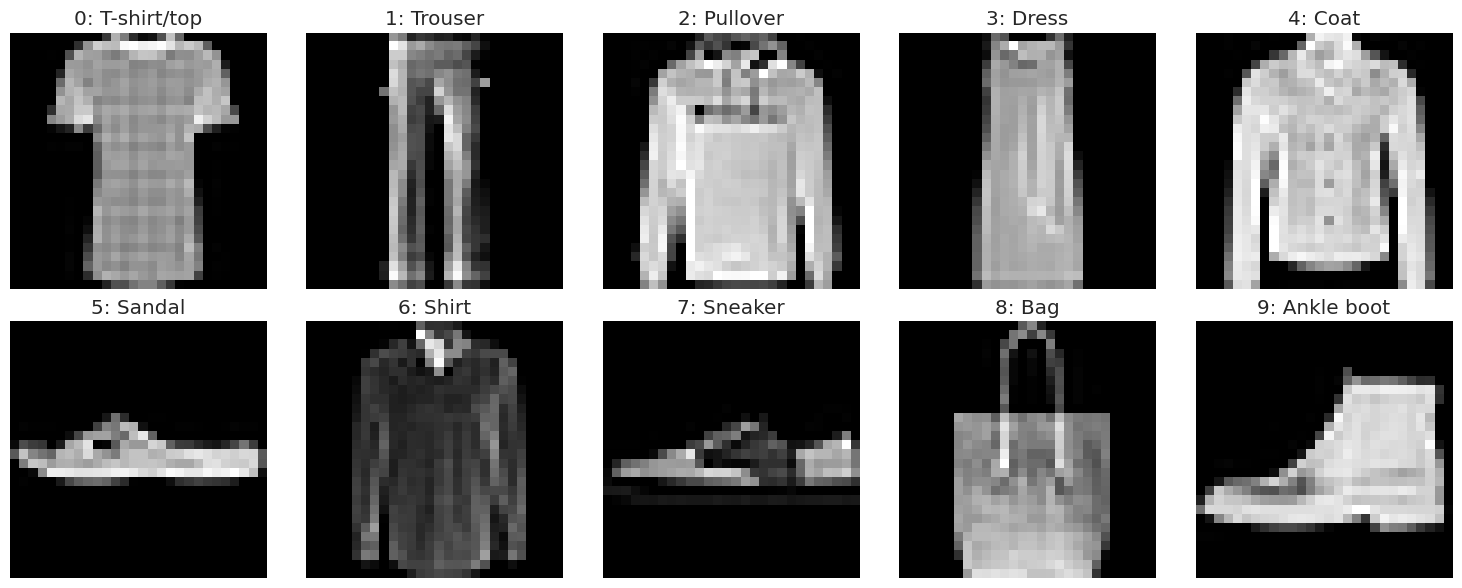

Training RNN model...
Epoch 1/15 - Loss: 1.3102 - Acc: 0.5722 - Val Loss: 0.9090 - Val Acc: 0.6793
Epoch 2/15 - Loss: 0.8165 - Acc: 0.7190 - Val Loss: 0.7291 - Val Acc: 0.7458
Epoch 3/15 - Loss: 0.6991 - Acc: 0.7520 - Val Loss: 0.6556 - Val Acc: 0.7690
Epoch 4/15 - Loss: 0.6363 - Acc: 0.7748 - Val Loss: 0.6092 - Val Acc: 0.7857
Epoch 5/15 - Loss: 0.5907 - Acc: 0.7951 - Val Loss: 0.5665 - Val Acc: 0.7972
Epoch 6/15 - Loss: 0.5574 - Acc: 0.8031 - Val Loss: 0.5288 - Val Acc: 0.8142
Epoch 7/15 - Loss: 0.5311 - Acc: 0.8124 - Val Loss: 0.5046 - Val Acc: 0.8220
Epoch 8/15 - Loss: 0.5113 - Acc: 0.8196 - Val Loss: 0.4916 - Val Acc: 0.8248
Epoch 9/15 - Loss: 0.4974 - Acc: 0.8243 - Val Loss: 0.4956 - Val Acc: 0.8242
Epoch 10/15 - Loss: 0.4846 - Acc: 0.8286 - Val Loss: 0.4716 - Val Acc: 0.8353
Epoch 11/15 - Loss: 0.4741 - Acc: 0.8321 - Val Loss: 0.4717 - Val Acc: 0.8295
Epoch 12/15 - Loss: 0.4662 - Acc: 0.8345 - Val Loss: 0.4580 - Val Acc: 0.8367
Epoch 13/15 - Loss: 0.4579 - Acc: 0.8374 - Val Loss

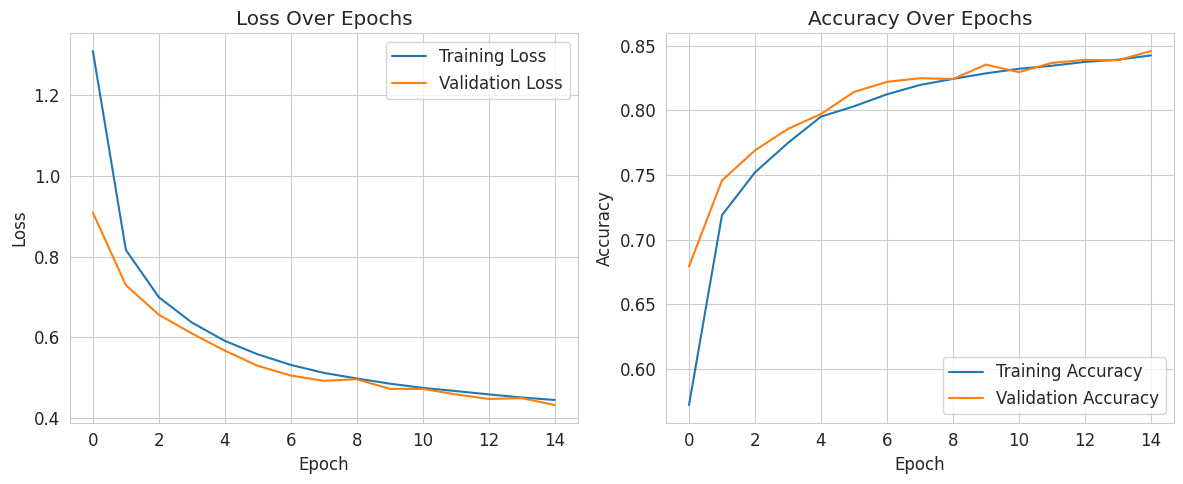


Evaluating RNN model on test set:
Accuracy: 0.8347
Precision: 0.8332
Recall: 0.8347
F1 Score: 0.8336


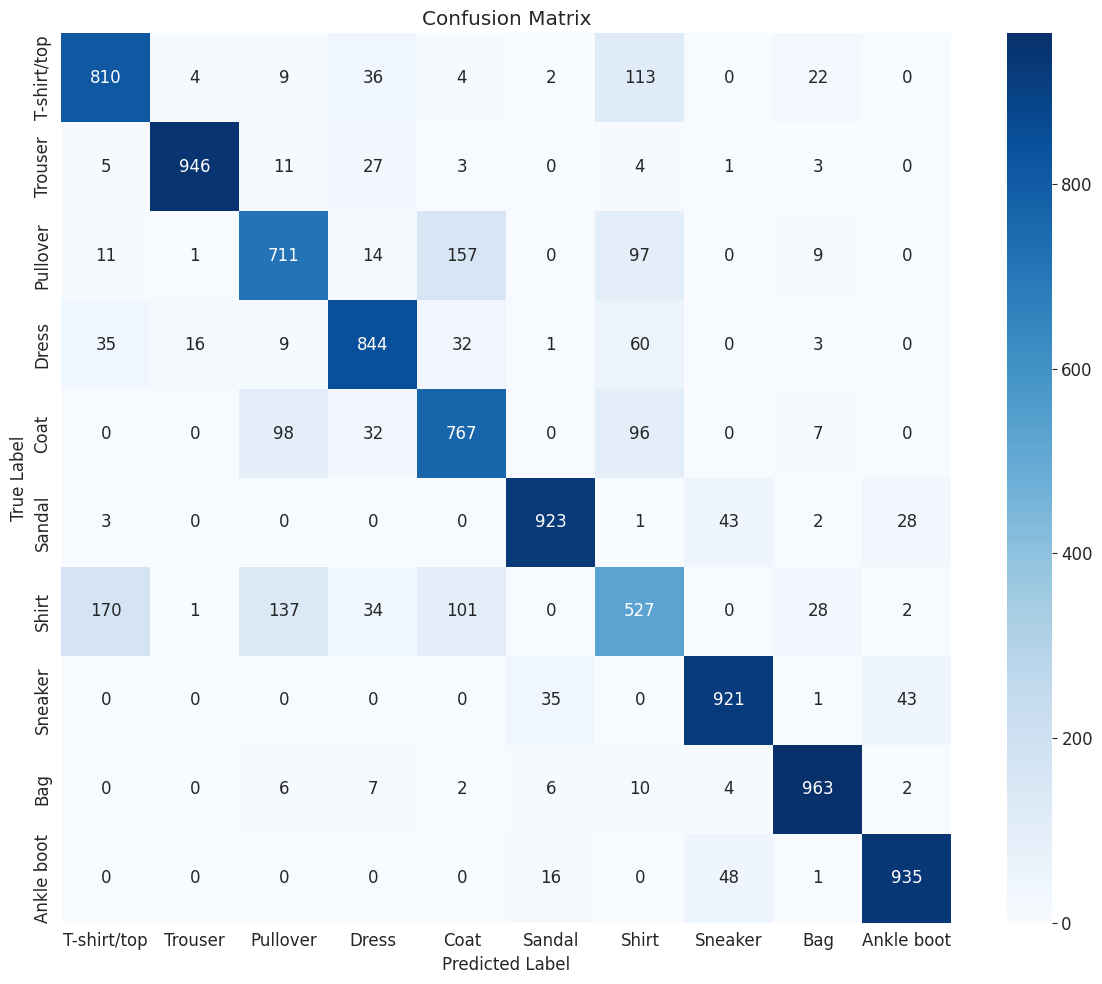

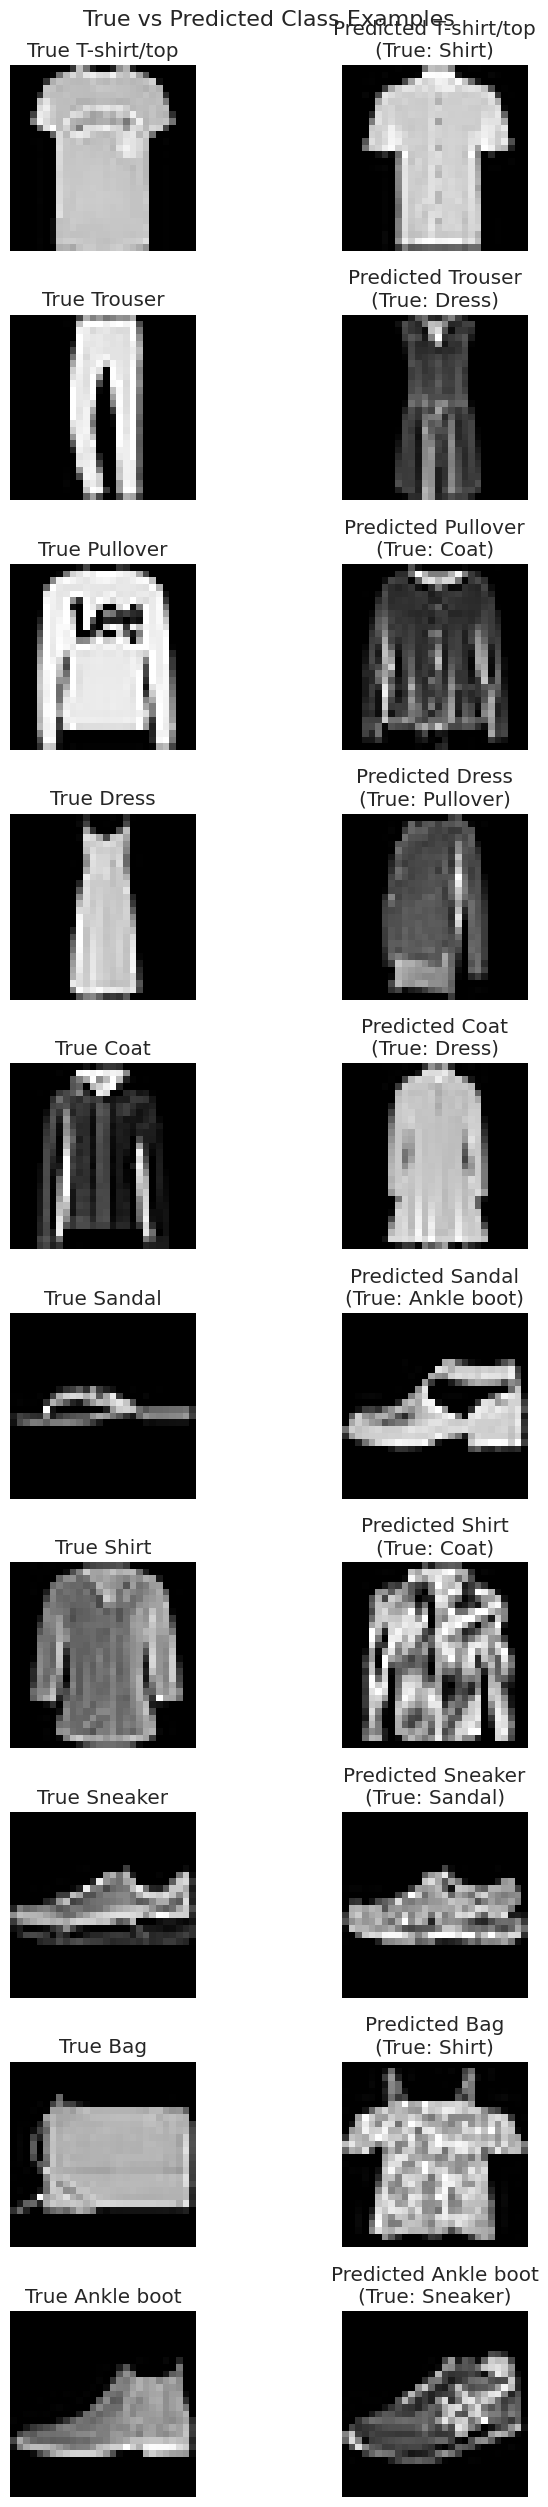

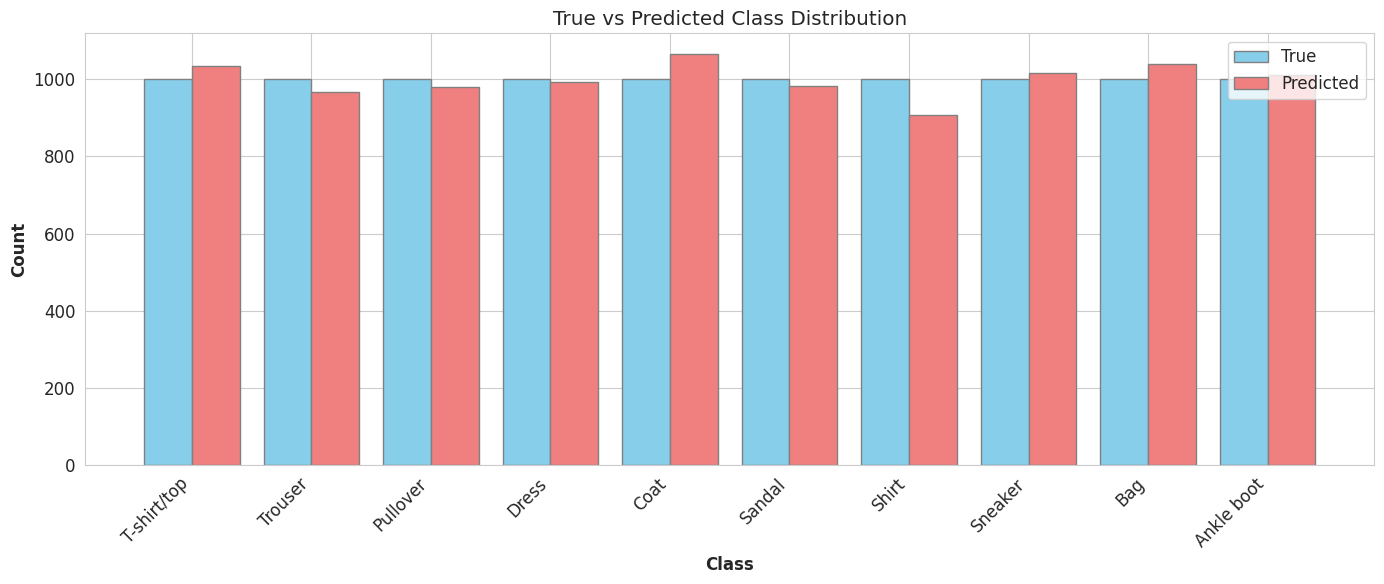

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Load Fashion MNIST dataset
def load_fashion_mnist():
    # Only using Keras/TensorFlow for dataset loading
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    # Normalize pixel values to [0, 1]
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0

    # For RNN, we'll treat each row of the image as a time step, with 28 features (columns)

    # One-hot encode labels
    y_train_onehot = one_hot_encode(y_train)
    y_test_onehot = one_hot_encode(y_test)

    return X_train, y_train_onehot, X_test, y_test_onehot, y_train, y_test

def one_hot_encode(y, num_classes=10):
    """Convert labels to one-hot encoding"""
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

# RNN from scratch
class RNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size  # Number of features per time step
        self.hidden_size = hidden_size  # Size of hidden state
        self.output_size = output_size  # Number of output classes
        self.learning_rate = learning_rate
        self.parameters = {}
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        # Initialize parameters
        # For RNN cell: h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b_h)
        # Xavier/Glorot initialization
        scale_xh = np.sqrt(2.0 / (input_size + hidden_size))
        scale_hh = np.sqrt(2.0 / (hidden_size + hidden_size))
        scale_hy = np.sqrt(2.0 / (hidden_size + output_size))

        self.parameters['Wxh'] = np.random.randn(input_size, hidden_size) * scale_xh  # Input to hidden
        self.parameters['Whh'] = np.random.randn(hidden_size, hidden_size) * scale_hh  # Hidden to hidden
        self.parameters['bh'] = np.zeros((1, hidden_size))  # Hidden bias

        # Output layer parameters
        self.parameters['Why'] = np.random.randn(hidden_size, output_size) * scale_hy  # Hidden to output
        self.parameters['by'] = np.zeros((1, output_size))  # Output bias

    def tanh(self, x):
        """Tanh activation function"""
        return np.tanh(x)

    def tanh_derivative(self, x):
        """Derivative of tanh: 1 - tanh^2(x)"""
        return 1 - np.power(np.tanh(x), 2)

    def softmax(self, x):
        """Softmax activation for output layer"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        """Cross-entropy loss function"""
        m = y_true.shape[0]
        # Add small epsilon to avoid log(0)
        log_probs = -np.log(y_pred + 1e-10) * y_true
        loss = np.sum(log_probs) / m
        return loss

    def forward_pass(self, X):
        """
        Forward propagation through the RNN
        X shape: (batch_size, time_steps, input_size)
        """
        batch_size, time_steps, _ = X.shape

        # Initialize hidden state with zeros
        h_prev = np.zeros((batch_size, self.hidden_size))

        # Store intermediate values for backpropagation
        cache = {
            'X': X,
            'h': {},
            'h_raw': {},  # Pre-activation hidden states
            'y_pred': {}
        }

        # Process each time step
        for t in range(time_steps):
            # Get current time step input
            x_t = X[:, t, :]

            # Compute hidden state
            h_raw_t = np.dot(x_t, self.parameters['Wxh']) + \
                      np.dot(h_prev, self.parameters['Whh']) + \
                      self.parameters['bh']
            h_t = self.tanh(h_raw_t)

            # Store values for backpropagation
            cache['h_raw'][t] = h_raw_t
            cache['h'][t] = h_t

            # Update previous hidden state
            h_prev = h_t

        # Final hidden state becomes the input to the output layer
        y_raw = np.dot(h_prev, self.parameters['Why']) + self.parameters['by']
        y_pred = self.softmax(y_raw)

        cache['y_raw'] = y_raw
        cache['y_pred'] = y_pred
        cache['h_last'] = h_prev  # Final hidden state

        return y_pred, cache

    def backward_pass(self, y_pred, y_true, cache):
        """
        Backward propagation through time (BPTT)
        """
        batch_size, time_steps, _ = cache['X'].shape
        gradients = {}

        # Initialize gradients
        gradients['dWxh'] = np.zeros_like(self.parameters['Wxh'])
        gradients['dWhh'] = np.zeros_like(self.parameters['Whh'])
        gradients['dbh'] = np.zeros_like(self.parameters['bh'])
        gradients['dWhy'] = np.zeros_like(self.parameters['Why'])
        gradients['dby'] = np.zeros_like(self.parameters['by'])

        # Gradient of output layer
        dy = y_pred - y_true  # Shape: (batch_size, output_size)
        gradients['dWhy'] = np.dot(cache['h_last'].T, dy) / batch_size
        gradients['dby'] = np.sum(dy, axis=0, keepdims=True) / batch_size

        # Gradient flowing back to the last hidden state
        dh_next = np.dot(dy, self.parameters['Why'].T)

        # Backpropagate through time
        for t in reversed(range(time_steps)):
            # Gradient through tanh
            dh_raw = dh_next * self.tanh_derivative(cache['h_raw'][t])

            # Gradient of biases
            gradients['dbh'] += np.sum(dh_raw, axis=0, keepdims=True) / batch_size

            # Gradient of weight matrices
            x_t = cache['X'][:, t, :]
            gradients['dWxh'] += np.dot(x_t.T, dh_raw) / batch_size

            # For Whh, we need the previous hidden state, except for t=0
            if t > 0:
                h_prev = cache['h'][t-1]
            else:
                h_prev = np.zeros((batch_size, self.hidden_size))

            gradients['dWhh'] += np.dot(h_prev.T, dh_raw) / batch_size

            # Gradient flowing to the previous hidden state
            dh_next = np.dot(dh_raw, self.parameters['Whh'].T)

        # Clip gradients to mitigate exploding gradients
        # CHANGED: Modified gradient clipping threshold from (-5,5) to (-3,3) for more conservative updates
        for key in gradients:
            np.clip(gradients[key], -3, 3, out=gradients[key])

        return gradients

    def update_parameters(self, gradients):
        """Update parameters using gradients"""
        for key in self.parameters:
            self.parameters[key] -= self.learning_rate * gradients['d' + key]

    def train(self, X_train, y_train, X_val=None, y_val=None, batch_size=32, epochs=10):
        """Train the RNN model"""
        num_samples = X_train.shape[0]
        num_batches = int(np.ceil(num_samples / batch_size))

        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(num_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            epoch_loss = 0
            correct_predictions = 0

            for batch in range(num_batches):
                start_idx = batch * batch_size
                end_idx = min(start_idx + batch_size, num_samples)

                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # Forward pass
                y_pred, cache = self.forward_pass(X_batch)

                # Calculate loss
                batch_loss = self.cross_entropy_loss(y_pred, y_batch)
                epoch_loss += batch_loss * (end_idx - start_idx)

                # Count correct predictions
                batch_correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
                correct_predictions += batch_correct

                # Backward pass
                gradients = self.backward_pass(y_pred, y_batch, cache)

                # Update parameters
                self.update_parameters(gradients)

            # Calculate epoch metrics
            epoch_loss /= num_samples
            epoch_accuracy = correct_predictions / num_samples
            self.history['train_loss'].append(epoch_loss)
            self.history['train_acc'].append(epoch_accuracy)

            # Validation if provided
            if X_val is not None and y_val is not None:
                val_pred, _ = self.predict_with_batch(X_val, batch_size=batch_size)
                val_loss = self.cross_entropy_loss(val_pred, y_val)
                val_accuracy = np.mean(np.argmax(val_pred, axis=1) == np.argmax(y_val, axis=1))
                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_accuracy)
                print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_accuracy:.4f}")

    def predict_with_batch(self, X, batch_size=32):
        """Make predictions in batches to handle large datasets"""
        num_samples = X.shape[0]
        num_batches = int(np.ceil(num_samples / batch_size))

        all_preds = []
        all_caches = []

        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = min(start_idx + batch_size, num_samples)

            X_batch = X[start_idx:end_idx]
            y_pred, cache = self.forward_pass(X_batch)

            all_preds.append(y_pred)
            all_caches.append(cache)

        return np.vstack(all_preds), all_caches

    def predict(self, X):
        """Make predictions"""
        predictions, _ = self.predict_with_batch(X)
        return predictions

    def visualize_true_vs_predicted(self, X, y_true, class_names):
        """
        Visualize both true examples and predicted examples for each class

        Args:
            X: Input data
            y_true: True labels
            class_names: List of class names
        """
        # Get predictions
        y_pred = np.argmax(self.predict(X), axis=1)

        # Original shape of images
        n_rows = X.shape[1]  # Time steps
        n_cols = X.shape[2]  # Features per time step

        # Create a figure with subplots for each class (2 columns: true and predicted)
        fig, axes = plt.subplots(len(class_names), 2, figsize=(8, 25))

        for class_idx in range(len(class_names)):
            # Find samples with true label of this class
            true_indices = np.where(y_true == class_idx)[0]

            # Find samples predicted as this class
            pred_indices = np.where(y_pred == class_idx)[0]

            # True example
            if len(true_indices) > 0:
                true_img = X[true_indices[0]].reshape(n_rows, n_cols)
                axes[class_idx, 0].imshow(true_img, cmap='gray')
                axes[class_idx, 0].set_title(f"True {class_names[class_idx]}")
                axes[class_idx, 0].axis('off')
            else:
                axes[class_idx, 0].text(0.5, 0.5, "No samples", ha='center')
                axes[class_idx, 0].axis('off')

            # Predicted example (find examples where the model predicted this class)
            if len(pred_indices) > 0:
                # Find one that's not actually this class (misclassification) if possible
                misclassified = [idx for idx in pred_indices if y_true[idx] != class_idx]

                if len(misclassified) > 0:
                    # Show a misclassified example
                    pred_img = X[misclassified[0]].reshape(n_rows, n_cols)
                    true_label = y_true[misclassified[0]]
                    axes[class_idx, 1].imshow(pred_img, cmap='gray')
                    axes[class_idx, 1].set_title(f"Predicted {class_names[class_idx]}\n(True: {class_names[true_label]})")
                else:
                    # Show a correctly classified example
                    pred_img = X[pred_indices[0]].reshape(n_rows, n_cols)
                    axes[class_idx, 1].imshow(pred_img, cmap='gray')
                    axes[class_idx, 1].set_title(f"Predicted {class_names[class_idx]}\n(Correct)")

                axes[class_idx, 1].axis('off')
            else:
                axes[class_idx, 1].text(0.5, 0.5, "No predictions", ha='center')
                axes[class_idx, 1].axis('off')

        plt.tight_layout()
        plt.suptitle("True vs Predicted Class Examples", y=1.002, fontsize=16)
        plt.subplots_adjust(top=0.98)
        plt.show()

    def evaluate(self, X, y_true_onehot, y_true_labels, class_names=None):
        """Evaluate model performance with various metrics and visualize results"""
        # Get predictions
        y_pred = self.predict(X)
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred_labels == y_true_labels)
        conf_mat = confusion_matrix(y_true_labels, y_pred_labels)
        precision = precision_score(y_true_labels, y_pred_labels, average='macro')
        recall = recall_score(y_true_labels, y_pred_labels, average='macro')
        f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Plot confusion matrix
        plt.figure(figsize=(12, 10))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names if class_names else range(10),
                   yticklabels=class_names if class_names else range(10))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

        # Visualize true vs predicted samples for each class
        if class_names:
            self.visualize_true_vs_predicted(X, y_true_labels, class_names)

        # If class names are provided, visualize class distribution
        if class_names:
            self.plot_class_distribution(y_true_labels, y_pred_labels, class_names)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': conf_mat
        }

    def plot_class_distribution(self, y_true, y_pred, class_names):
        """Plot the distribution of true vs predicted classes"""
        plt.figure(figsize=(14, 6))

        # Count instances of each class
        true_counts = np.bincount(y_true, minlength=len(class_names))
        pred_counts = np.bincount(y_pred, minlength=len(class_names))

        # Set width of bars
        barWidth = 0.4

        # Set position of bars on X axis
        r1 = np.arange(len(class_names))
        r2 = [x + barWidth for x in r1]

        # Create bars
        plt.bar(r1, true_counts, width=barWidth, label='True', color='skyblue', edgecolor='grey')
        plt.bar(r2, pred_counts, width=barWidth, label='Predicted', color='lightcoral', edgecolor='grey')

        # Add labels and legend
        plt.xlabel('Class', fontweight='bold')
        plt.ylabel('Count', fontweight='bold')
        plt.title('True vs Predicted Class Distribution')
        plt.xticks([r + barWidth/2 for r in range(len(class_names))], class_names, rotation=45, ha='right')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_history(self):
        """Plot training history"""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Training Loss')
        if 'val_loss' in self.history and self.history['val_loss']:
            plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Training Accuracy')
        if 'val_acc' in self.history and self.history['val_acc']:
            plt.plot(self.history['val_acc'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def visualize_class_samples(self, X, y, class_names):
        """Visualize sample images from each class"""
        # Get original shape of images
        n_rows = X.shape[1]  # Time steps
        n_cols = X.shape[2]  # Features per time step

        # Create a figure with subplots for each class
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.flatten()

        for i, class_idx in enumerate(range(len(class_names))):
            # Find indices of samples from this class
            indices = np.where(y == class_idx)[0]

            if len(indices) > 0:
                # Take the first sample from this class
                sample_idx = indices[0]
                # Reshape the sample back to an image
                sample_image = X[sample_idx].reshape(n_rows, n_cols)

                # Display the image
                axes[i].imshow(sample_image, cmap='gray')
                axes[i].set_title(f"{class_idx}: {class_names[class_idx]}")
                axes[i].axis('off')

        plt.tight_layout()
        plt.show()

# Function to split data into training and validation sets
def train_val_split(X, y_onehot, y_labels, val_ratio=0.1):
    num_samples = X.shape[0]
    indices = np.random.permutation(num_samples)
    val_size = int(val_ratio * num_samples)

    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    X_train, X_val = X[train_indices], X[val_indices]
    y_train_onehot, y_val_onehot = y_onehot[train_indices], y_onehot[val_indices]
    y_train_labels, y_val_labels = y_labels[train_indices], y_labels[val_indices]

    return X_train, y_train_onehot, X_val, y_val_onehot, y_train_labels, y_val_labels

# Main execution
if __name__ == "__main__":
    # Set style for plots
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})

    # Define class names for Fashion MNIST
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Load Fashion MNIST dataset
    X_train, y_train_onehot, X_test, y_test_onehot, y_train_labels, y_test_labels = load_fashion_mnist()

    # Split training data to get validation set
    X_train, y_train_onehot, X_val, y_val_onehot, y_train_labels, y_val_labels = train_val_split(
        X_train, y_train_onehot, y_train_labels, val_ratio=0.1
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Input shape: {X_train.shape[1:]} (time_steps, features)")

    # Create and train RNN model
    input_size = 28  # Each time step has 28 features (columns of the image)
    hidden_size = 256  # CHANGED: Increased hidden state size from 128 to 256 for more capacity
    output_size = 10  # 10 fashion item classes

    # Create RNN instance
    rnn = RNN(input_size, hidden_size, output_size, learning_rate=0.001)  # CHANGED: Reduced learning rate from 0.005 to 0.001 for more stable training

    # Visualize sample images from each class before training
    print("Visualizing sample images from each class:")
    rnn.visualize_class_samples(X_train, y_train_labels, class_names)

    # Train model
    print("Training RNN model...")
    start_time = time.time()
    rnn.train(X_train, y_train_onehot, X_val, y_val_onehot, batch_size=64, epochs=15)  # CHANGED: Increased batch_size from 32 to 64 for faster training and epochs from 10 to 15 for better convergence
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Plot training history
    rnn.plot_history()

    # Evaluate on test set
    print("\nEvaluating RNN model on test set:")
    metrics = rnn.evaluate(X_test, y_test_onehot, y_test_labels, class_names)